In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
%matplotlib inline

import spacy
nlp = spacy.load("en_core_web_sm")

import nltk
from nltk.tokenize import sent_tokenize
from nltk import pos_tag, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from textblob import TextBlob
from textblob import Word

In [2]:
s = "Apple is looking at buying U.K. startup for $1 billion"

In [3]:
doc = nlp(s)
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Apple Apple PROPN NNP nsubj Xxxxx True False
is be AUX VBZ aux xx True True
looking look VERB VBG ROOT xxxx True False
at at ADP IN prep xx True True
buying buy VERB VBG pcomp xxxx True False
U.K. U.K. PROPN NNP dobj X.X. False False
startup startup VERB VBD dep xxxx True False
for for ADP IN prep xxx True True
$ $ SYM $ quantmod $ False False
1 1 NUM CD compound d False False
billion billion NUM CD pobj xxxx True False


In [4]:
doc = nlp("She saw a bear.")
for token in doc:
    print(token.text, token.pos_)

She PRON
saw VERB
a DET
bear NOUN
. PUNCT


In [5]:
doc = nlp("Your efforts will bear fruit.")
for token in doc:
    print(token.text, token.pos_)

Your PRON
efforts NOUN
will AUX
bear VERB
fruit NOUN
. PUNCT


In [6]:
doc = nlp("Please book my flight to California")
for token in doc:
    print(token.text, token.pos_)

Please INTJ
book VERB
my PRON
flight NOUN
to ADP
California PROPN


In [7]:
doc = nlp("I read a very good book")
for token in doc:
    print(token.text, token.pos_)

I PRON
read VERB
a DET
very ADV
good ADJ
book NOUN


In [8]:
tokenized_sent = sent_tokenize("She saw a bear.")

[nltk.pos_tag(nltk.word_tokenize(word)) for word in tokenized_sent]

[[('She', 'PRP'), ('saw', 'VBD'), ('a', 'DT'), ('bear', 'NN'), ('.', '.')]]

In [9]:
tokenized_sent = sent_tokenize("Your efforts will bear fruit.")

[nltk.pos_tag(nltk.word_tokenize(word)) for word in tokenized_sent]

[[('Your', 'PRP$'),
  ('efforts', 'NNS'),
  ('will', 'MD'),
  ('bear', 'VB'),
  ('fruit', 'NN'),
  ('.', '.')]]

In [10]:
tokenized_sent = sent_tokenize("Please book my flight to California")

[nltk.pos_tag(nltk.word_tokenize(word)) for word in tokenized_sent]

[[('Please', 'NNP'),
  ('book', 'NN'),
  ('my', 'PRP$'),
  ('flight', 'NN'),
  ('to', 'TO'),
  ('California', 'NNP')]]

In [11]:
tokenized_sent = sent_tokenize("I read a very good book")

[nltk.pos_tag(nltk.word_tokenize(word)) for word in tokenized_sent]

[[('I', 'PRP'),
  ('read', 'VBP'),
  ('a', 'DT'),
  ('very', 'RB'),
  ('good', 'JJ'),
  ('book', 'NN')]]

In [12]:
doc = nlp("Autonomous cars shift insurance liability toward auto manufacturers")
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_,
            chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
auto manufacturers manufacturers pobj toward


In [13]:
doc = nlp("Autonomous cars shift insurance liability toward auto manufacturers")
for chunk in doc.noun_chunks:
    print(chunk.text)

Autonomous cars
insurance liability
auto manufacturers


In [14]:
text = ("Autonomous cars shift insurance liability toward auto manufacturers")
blob = TextBlob(text)
print(blob.noun_phrases)

['autonomous', 'insurance liability', 'auto manufacturers']


In [15]:
df = pd.read_csv("ClothingReviews.csv")
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses


In [16]:
df.dropna(subset=['Department Name', 'Class Name', 'Review Text'], inplace=True)

In [17]:
df['Title'].fillna('', inplace=True)

In [18]:
df['Text'] = df['Title'] + ' ' + df['Review Text']

In [ ]:
# df.drop(columns=['Title', 'Review Text'], inplace=True)

## Text Cleaning

For **Parts** of our analysis, the text needs to have some basic transformation for our models to work propertly.  These are as follows:

1. **Lower**: Convert all characters to lowercase
1. **Remove Punctuation**: In most cases, punctuation doesn't help NLP and ML models and can be removed.
1. **Stop Word Removal**: Stop words generally don't add context to analysis (unless the length of text is very short (`100` - `200` characters) and can be removed.
1. **Lemmatization**: Words will be reduced to there *Lemma* or root.  This will greatly improve the accuracy of the analysis since words like `simming` and `swimmer` will be reduced to `swim`.

**Note**: The orginal text will be preserved for other analysis.

In [19]:
df['Review Text'][2]

'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'

In [20]:
def process_string(text, stem="None"):
    
    final_string = ""
    
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    text_filtered = [word for word in text if not word in useless_words]
    
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered
    
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [21]:
df['Text_Processed'] = df['Review Text'].apply(lambda x: process_string(x, stem='Lem'))

In [22]:
df['Text_Processed'][2]

'high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sewn directly zipper c '

# Part-of-speech Tagging

In this portion of the analysis, we will use a method known as Part of Speech tagging or POS.  This method uses a lexicon-based lookup to identify what parts of speech words are, such as Nouns, Verbs, Adjectives, and Adverbs.  By utilizing these, we can perform various analysis such as the following:

- Word counts for different parts of speech to start giving us an overview of the most common parts of language used.
- Identify nouns used to tag products (e.g., dress, jacket, bottom, etc.).  This will give us a different look at the popularity of items vs. simply counting categories.
- Finally, we'll identify the top adjectives and adverbs for positive vs. negative reviews, telling us what words are used in each sentiment to describe the products.

## POS Tagging with Spacy

In [148]:
def pos_tag(text):
    
    df = pd.DataFrame(columns = ['Word', 'POS'])
    
    doc = nlp(text)
    for token in doc:
        df = df.append({'Word': token.text, 'POS': token.pos_}, ignore_index=True)
        
    return df

In [173]:
# Take a random sample of reviews (5,000)
df2 = df.sample(5000, random_state=42).copy()
# Create an empty dataframe to store the results
df_pos = pd.DataFrame(columns = ['Word', 'POS'])
# Iterate through the reviews and append each POS tag to the dataframe
df_pos = pos_tag(df2['Review Text'].to_string())
df_pos.shape

(70638, 2)

In [184]:
# Get rid of some of the uninteresting POS tags
df_pos = df_pos[(df_pos['POS'] != 'SPACE') & (df_pos['POS'] != 'PUNCT') & (df_pos['POS'] != 'NUM')]

In [185]:
df_top_pos = df_pos.groupby('POS')['POS'].count().\
    reset_index(name='count').sort_values(['count'],ascending=False).head(15)

In [186]:
df_top_pos

,POS,count
7,NOUN,8870
9,PRON,6501
5,DET,5830
13,VERB,5392
0,ADJ,4697
3,AUX,3558
1,ADP,3305
2,ADV,2786
4,CCONJ,2024
10,PROPN,1469


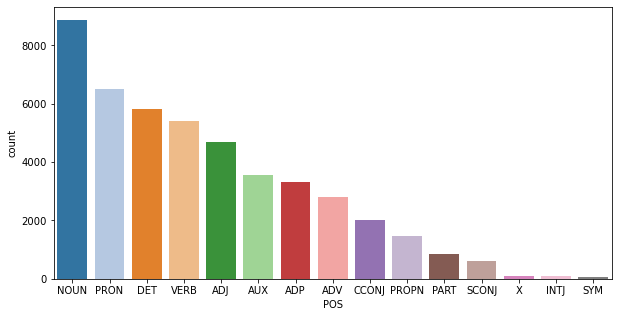

In [187]:
plt.figure(figsize=(10,5))
sns.barplot(data =df_top_pos, x='POS', y='count', palette="tab20");

### Identify Top Product Nouns

In [188]:
df_nn = df_pos[df_pos['POS'] == 'NOUN'].copy()

In [189]:
df_nn.groupby('Word')['Word'].count().reset_index(name='count').\
    sort_values(['count'], ascending=False).head(10)

,Word,count
401,dress,858
1335,top,557
1274,sweater,229
1123,shirt,211
281,color,192
1154,size,169
459,fabric,144
1167,skirt,142
886,pants,134
1231,store,123


In [190]:
df_adj = df_pos[df_pos['POS'] == 'ADJ'].copy()

In [191]:
df_adj.groupby('Word')['Word'].count().reset_index(name='count').\
    sort_values(['count'], ascending=False).head(10)

,Word,count
276,great,228
84,beautiful,191
169,cute,178
522,soft,161
143,comfortable,136
421,perfect,108
392,nice,97
514,small,81
273,gorgeous,77
446,pretty,73


# POS Tagging with TextBlob

In [118]:
# Tokenize the words
df['Text_Tok'] = df['Text_Processed'].apply(word_tokenize)

In [119]:
def parse_text(x):
    '''using TextBlob, get the full parsed results (POS, etc)'''
    blob = TextBlob(x)
    p = blob.parse()
    p = re.sub(r'^\w+/', '',p)
    return p.split('/')

In [120]:
def build_pos(x):
    '''pass a DataFrame column with tokenized text and return a DF of the Words'''
    
    # Build a list of all the words in the text.  List comprehension is fastest.
    all_words = [word for words in x for word in words]
    
    # Create a new DF for the list
    df = pd.DataFrame(all_words)
    df.columns = ['Word']
    
    # Add a column for the POS
    df['Parse'] = df['Word'].apply(lambda x: parse_text(x))
    
    # Expned the extracted list of POS tags into their own columns, and concat that back to the orig DF
    # https://chrisalbon.com/python/data_wrangling/pandas_expand_cells_containing_lists/
    par = pd.DataFrame(df['Parse'].to_list(), columns=['P1','P2', 'P3', 'P4'])
    df = pd.concat([df[:], par[:]], axis=1)
    df.drop(columns=['Parse'], inplace=True)

    return df

In [121]:
df_words = build_pos(df['Text_Tok'])

In [122]:
df_words.sample(10)

,Word,P1,P2,P3,P4
643069,fit,VB,B-VP,O,None
474973,problem,NN,B-NP,O,None
104983,amazing,JJ,B-ADJP,O,None
392558,pretty,RB,B-ADVP,O,None
75362,jean,NN,B-NP,O,None
142577,look,VB,B-VP,O,None
24583,beyond,IN,B-PP,O,None
460156,going,VBG,B-VP,O,None
243637,agree,VB,B-VP,O,None
523671,bit,NN,B-NP,O,None


**Notes:** Rather than using the much simpler approach of the POS with the TextBlog `tags` function[1], We used the `parse` function since it provides more verbose labeling text.

The attempt here was to discover if there was a better way to identify nouns that would represent product features vs. other nouns.  Unfortunately, this didn't end up providing the detail needed. More information on this is presented below.

## Word Counts for Different Parts of Speech

In [123]:
df_top_pos = df_words.groupby('P1')['P1'].count().\
    reset_index(name='count').sort_values(['count'],ascending=False).head(15)

In [124]:
df_top_pos

,P1,count
10,NN,251471
6,JJ,146392
19,VB,62527
15,RB,52856
20,VBD,37135
22,VBN,22712
1,CD,19122
5,IN,17160
21,VBG,16364
23,VBP,13755


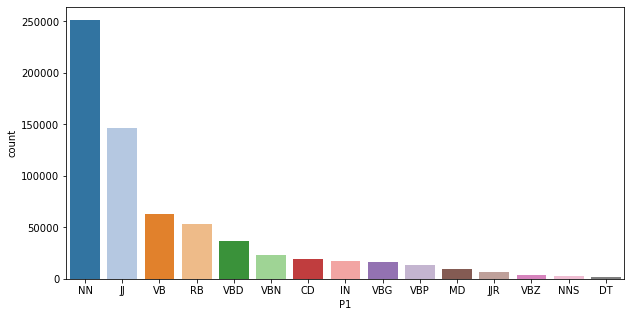

In [125]:
plt.figure(figsize=(10,5))
sns.barplot(data =df_top_pos, x='P1', y='count', palette="tab20");

## Identify Top Product Nouns

In [132]:
df_nn = df_words[df_words['P1'] == 'NN'].copy()

In [133]:
df_nn.groupby('Word')['Word'].count().reset_index(name='count').\
    sort_values(['count'], ascending=False).head(10)

,Word,count
2855,dress,11319
7926,size,9347
5187,love,8962
2054,color,6902
3211,fabric,4843
1173,bit,2874
5357,material,2814
7745,shirt,2791
8631,sweater,2689
4952,length,2629


**Notes**:  When inspecting `nouns` only, there is a mix of different types of words displayed, and some we can see are not tagged in such a way that seems to make sense with this dataset.  For example, `love` is tagged as a noun, but it's probably an adjective.  `bit` is probably referring to an adjective as well but is showing as a noun.

We can inspect these words directly to see if there is a difference in their POS tags.

In [134]:
print(TextBlob('dress').parse())
print(TextBlob('love').parse())
print(TextBlob('bit').parse())

dress/NN/B-NP/O
love/NN/B-NP/O
bit/NN/B-NP/O


**Observations:**  When we try to use the Part of Speech (POS) tagging, there isn't a distinction between Nouns.  Each of these has the same POS sequence. 

We can use the Class name to determine clothing nouns to use.  

In [135]:
# Extract a list of all the unique class names
noun_types = list(df['Class Name'].unique())

# The words from the categories need to be lemmatized.
lem = WordNetLemmatizer()
for i in range(len(noun_types)):
    noun_types[i] = lem.lemmatize(noun_types[i].lower())
noun_types

['intimate',
 'dress',
 'pant',
 'blouse',
 'knit',
 'outerwear',
 'lounge',
 'sweater',
 'skirt',
 'fine gauge',
 'sleep',
 'jacket',
 'swim',
 'trend',
 'jean',
 'legwear',
 'short',
 'layering',
 'casual bottoms',
 'chemise']

In [136]:
# Extract all the text into a huge string and use Text Blobs to get a Dictionary out with counts
all_text = ' '.join(df['Text_Processed'])
all_text_blob = TextBlob(all_text)
all_text_dict = all_text_blob.word_counts

# Turn the dictionary into a Dataframe.  Filter by the word list and then sort for plotting.
df_dict = pd.DataFrame(list(all_text_dict.items()),columns = ['Word','Count']) 
df_products = df_dict[df_dict.Word.isin(noun_types)]
df_products.sort_values(by=['Count'], inplace=True, ascending=False)
df_products

/Users/brianroepke/miniforge3/envs/POS/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Word,Count
6,dress,11319
445,sweater,2689
355,jean,2592
450,short,2354
102,skirt,2217
150,pant,2053
502,jacket,1284
333,blouse,1006
495,knit,466
496,layering,222


**Observations**: Based on the top outputs, we can see that `dresses` are the largest mentioned product line at a rate of `4x` the second, `sweaters`.

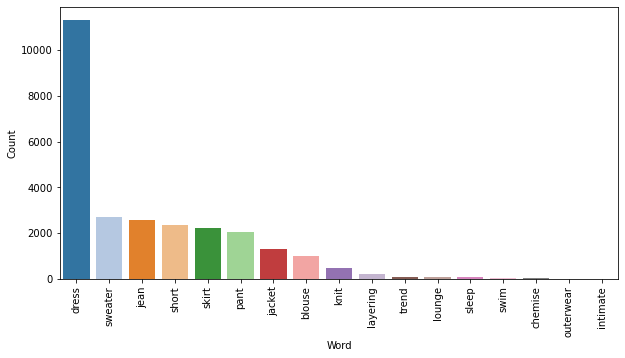

In [137]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='Word', y='Count', data=df_products, palette="tab20", dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);